In [21]:
# En primer lugar, consideraremos como banco de prueba la estación con mediciones más antiguas
# Se trata de la estacion localizada en Milan que tiene información desde 1763

import sqlite3

# Abrimos la conexión con la BBDD
conn = sqlite3.connect("D:/master/Master-in-Data-Science/Proyecto/Datos/worldTimeSeries.sqlite")
cursor = conn.cursor()

In [37]:
from pandas import DataFrame,Series
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 3
import time

In [23]:
# Realizamos la query
station = 'ITE00100554'

# Se calcula la temperatura media por cada uno de los meses
rows = cursor.execute("""select 
                            date, 
                            TMAX, 
                            TMIN, 
                            PRCP
                        from world_time_europa
                        where STATION = '"""+station+"';")

df = DataFrame(rows.fetchall())
print(len(df))
df.columns = ["date","tmax","tmin","prcp"]
df.head()

89786


,date,tmax,tmin,prcp
0,17630101,-3.6,-5.0,NaN
1,17630102,-2.6,-4.0,NaN
2,17630103,-0.9,-2.9,NaN
3,17630104,-0.4,-2.4,NaN
4,17630105,2.1,0.1,NaN


In [24]:
# Tenemos una serie temporal con un total de 89,786 registros, lo que para hacer un análisis inicial es un nivel 
# muy detallado por tanto, vamos a reducir el conjunto de datos realizando la media de cada unidad por año

df["year"] = df.date.map(lambda x: int(x[:4]))
estadisticas = {"tmax":{"tmax":"median","nobs":"count"},
                "tmin":{"tmin":"median"},
                "prcp":{"prcp":"median"}}

df_agg = df.groupby("year").agg(estadisticas)
df_agg.columns = df_agg.columns.droplevel()

In [25]:
df_agg.head()

,nobs,tmax,prcp,tmin
year,,,,
1763,365,14.70,NaN,9.9
1764,366,14.85,NaN,9.3
1765,365,15.70,NaN,11.6
1766,365,15.30,NaN,11.1
1767,365,15.30,NaN,9.7


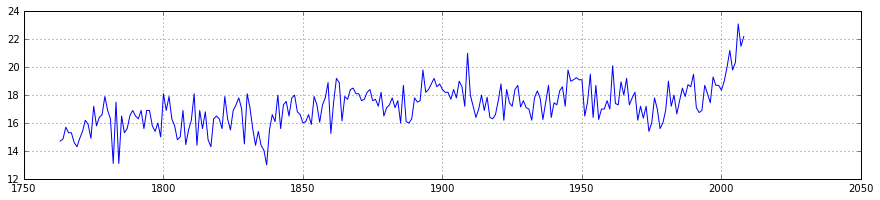

In [38]:
plt.plot(df_agg.tmax)
plt.grid(True)

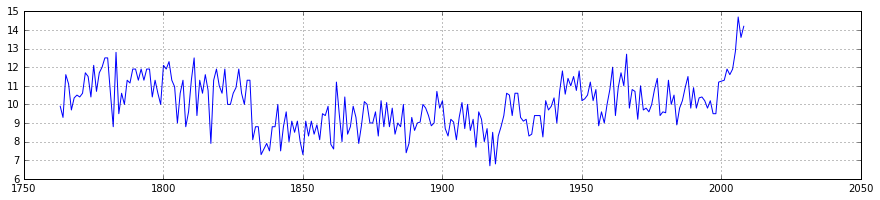

In [39]:
plt.plot(df_agg.tmin)
plt.grid(True)

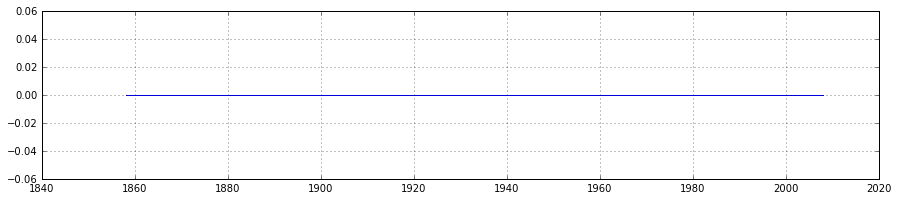

In [40]:
plt.plot(df_agg.prcp)
plt.grid(True)

In [30]:
df.tail()

,date,tmax,tmin,prcp,year
89781,20081127,9.4,3.3,0.0,2008
89782,20081128,5.5,1.1,0.0,2008
89783,20081129,8.7,1.9,24.8,2008
89784,20081130,6.7,3.1,26.4,2008
89785,20081201,NaN,NaN,7.4,2008


Se observa que efectivamente en los últimos años de la serie se presentan anomalías en los 3 indicadores, pero no tenemos la información completa, ya que el último dato disponible de la estación data de 2008, por tanto tenemos que localizar una estacion en una localización con similares características para poder extrapolar las medidas de la estación de Milan con esa nueva localizacion.

¿Desde que fecha debemos completar?

La serie se trunca en 2008, pero los datos anómalos que se observan desde 2006 parecen indicar anomalias en las observaciones, ya que rompe totalmente y muy bruscamente los datos. Si observamos la serie histórica, cada año hay 365 o 366 observaciones, salvo en los años de 2007 y 2008 que presentan 331 y 336 observaciones respectivamente, es decir que falta al menos 1 mes de observaciones, si esa falta estuviera distribuida uniformemente por todo el año podríamos inferir que la anomalía no es debida a esa falta de información, pero si sacamos el número de observaciones por mes, vemos que en 2007 faltan 4 días de Julio y 30 de Octubre, un mes en el que las temperaturas se reducen, por tanto podría explicar la subida en la temperatura media anual en 2 grados

Para 2008, se observa que faltan 30 días de Diciembre, el primer mes de invierno, que puede explicar el incremento observado en temperaturas y reducción de precipitaciones

En 2006, a pesar de ser el primer año con anomalías, parece que no es debido al tamaño de los datos, por tanto consideraremos que ese año la información es correcta. Por tanto para completar la información de la serie de Milan debemos buscar las observaciones de la estacion meteorológica más parecida desde el año 2007


In [31]:
# Para los años 2007 y 2008 revisamos qué días del año faltan
df["month"] = df.date.map(lambda x: int(x[:6]))
df_agg_month = df[["month","tmax"]].groupby("month").count()
df_agg_month = df_agg_month.reset_index()

In [32]:
df_2007 = df_agg_month[df_agg_month.month >= 200701]
df_2007 = df_2007[df_2007.month < 200801]

df_2008 = df_agg_month[df_agg_month.month >= 200801]
df_2008 = df_2008[df_2008.month < 200901]

In [33]:
df_2007

,month,tmax
2928,200701,31
2929,200702,28
2930,200703,31
2931,200704,30
2932,200705,31
2933,200706,30
2934,200707,27
2935,200708,31
2936,200709,30
2937,200710,1


In [34]:
df_2008

,month,tmax
2940,200801,31
2941,200802,29
2942,200803,31
2943,200804,30
2944,200805,31
2945,200806,30
2946,200807,31
2947,200808,31
2948,200809,30
2949,200810,31


En ambos casos falta información de 1 mes de otoño/invierno, justo cuando las temperaturas son más bajas, por tanto los picos observados en 2007 y 2008 no son válidos

Por simplicidad, vamos a considerar los mismos indicadores pero para cada cada continente, para ver si a nivel global se observa alguna tendencia

In [35]:
# Comenzamos con europa
continentes=["europa"]
#continentes=["europa","africa","asia","oceania","north_america","central_america","south_america","antarctida"]

for cont in continentes:
    # Se calcula la temperatura media por cada uno de los meses
    rows = cursor.execute("""select 
                            substr(date,1,4) as date, 
                            avg(TMAX) as TMAX, 
                            avg(TMIN) as TMIN, 
                            avg(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_"""+cont+""" 
                        group by substr(date,1,4)
                        order by substr(date,1,4);""")
    result=[]
    for r in rows:
        result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
   
    df_europa = DataFrame(result)

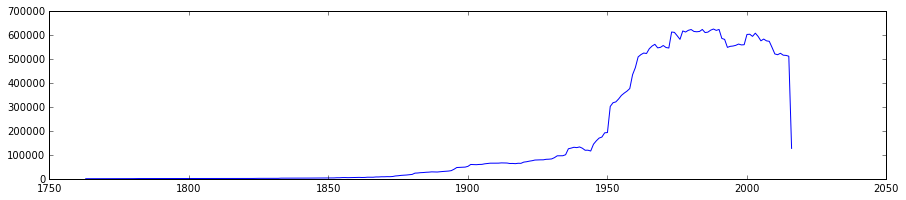

In [41]:
plt.plot(df_europa.date,df_europa.NOBS)

Se obserba que el número de estaciones no es constante a lo largo de la historia, se van incluyendo nuevas estaciones de medicion, principalmente a partir de 1950. Como nuestro estudio trata de ver una variación significativa en la evolución temporal, debemos tener al menos 100 años de observaciones de cada estacion, para determinar un patrón, para ello realizamos la query necesaria para quedarnos con las observaciones de las estaciones más antiguas, es decir, existentes en 1900


In [42]:
continentes=["europa"]
#continentes=["europa","africa","asia","oceania","north_america","central_america","south_america","antarctida"]

for cont in continentes:
    # Se recuperan todas las estaciones del continentes que existían en Enero de 1900
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19000101';")
    station_list_1900 = DataFrame(rows.fetchall())
    
    # Se compone la lista de estaciones para que lo entienda SQL
    stations = ""
    for s in station_list_1900.as_matrix():
        if stations != "":
            stations = stations + ","
        stations = stations + "'" + s[0] + "'"
            
    # Se calcula la temperatura media por cada uno de los meses
    rows = cursor.execute("""select 
                            date, 
                            sum(TMAX) as TMAX, 
                            sum(TMIN) as TMIN, 
                            sum(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_"""+cont+""" 
                        where station in ("""+stations+""") 
                        group by date
                        order by date;""")
    result=[]
    for r in rows:
        result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
   
    if cont == "europa":
        df_europa = DataFrame(result)
        
# Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas fuera del SQL
# Se calcula el año a partir de la fecha
df_europa['year'] = df_europa.date.map(lambda x: x[:4])
# Se realiza el group by por año
df_europa_agg = df_europa.groupby('year').sum()
# Se recalculan los indicadores
df_europa_agg = df_europa_agg.reset_index()
df_europa_agg.TMAX = df_europa_agg.TMAX/df_europa_agg.NOBS
df_europa_agg.TMIN = df_europa_agg.TMIN/df_europa_agg.NOBS
df_europa_agg.PRCP = df_europa_agg.PRCP/df_europa_agg.NOBS

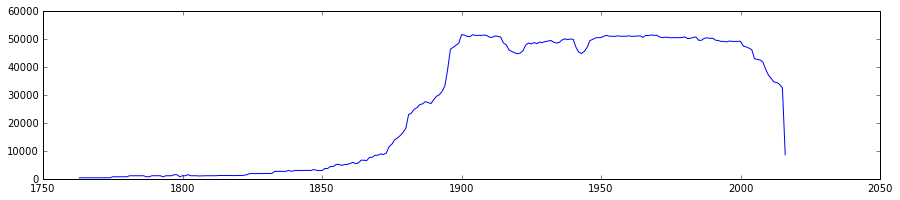

In [43]:
# Se representa la evolución del número de observaciones desde 1900
plt.plot(df_europa_agg.year,df_europa_agg.NOBS)

Se observa que algunas estaciones dejan de proveer información, por tanto nos interesan únicamente aquellas que siguen existiendo en 2016, más concretamente en Abril de 2016


In [44]:
continentes=["europa"]
#continentes=["europa","africa","asia","oceania","north_america","central_america","south_america","antarctida"]

for cont in continentes:
    # Se recuperan todas las estaciones del continentes que existían previamente a 1900 y existen en 2016
    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '19000101';")
        
    station_list_1900 = []
    for r in rows:
        station_list_1900.append({"station":r[0]})

    rows = cursor.execute("select distinct station from world_time_"+cont+" where date = '20160401';")        
    station_list_2016 = []
    for r in rows:
        station_list_2016.append({"station":r[0]})

    station_list_1900 = DataFrame(station_list_1900)
    station_list_2016 = DataFrame(station_list_2016)

    # Nos quedamos con las estaciones que estan en ambas listas
    station_list = station_list_1900.merge(station_list_2016)
    station_list = station_list.reset_index()
    
    # Se compone la lista de estaciones para que lo entienda SQL
    stations = ""
    for s in station_list.as_matrix():
        if stations != "":
            stations = stations + ","
        stations = stations + "'" + s[1] + "'"
            
    # Se calcula la temperatura media por cada uno de los meses
    rows = cursor.execute("""select 
                            date, 
                            sum(TMAX) as TMAX, 
                            sum(TMIN) as TMIN, 
                            sum(PRCP) as PRCP,
                            count(*) as NOBS
                        from world_time_"""+cont+""" 
                        where station in ("""+stations+""") 
                        group by date
                        order by date;""")
    result=[]
    for r in rows:
        result.append({"date":r[0],"TMAX":r[1],"TMIN":r[2],"PRCP":r[3],"NOBS":r[4]})
   
    if cont == "europa":
        df_europa = DataFrame(result)

# Para reducir el tiempo que consume la query anterior, se hace la media anual de temperaturas fuera del SQL
# Se calcula el año a partir de la fecha
df_europa['year'] = df_europa.date.map(lambda x: x[:4])
# Se realiza el group by por año
df_europa_agg = df_europa.groupby('year').sum()
# Se recalculan los indicadores
df_europa_agg = df_europa_agg.reset_index()
df_europa_agg.TMAX = df_europa_agg.TMAX/df_europa_agg.NOBS
df_europa_agg.TMIN = df_europa_agg.TMIN/df_europa_agg.NOBS
df_europa_agg.PRCP = df_europa_agg.PRCP/df_europa_agg.NOBS

In [46]:
df_europa_agg.head()

,year,NOBS,PRCP,TMAX,TMIN
0,1833,364,NaN,14.141209,5.137637
1,1834,365,NaN,15.741644,7.205753
2,1835,365,NaN,14.107397,5.665753
3,1836,366,NaN,13.880601,5.936339
4,1837,365,NaN,13.259452,5.254795


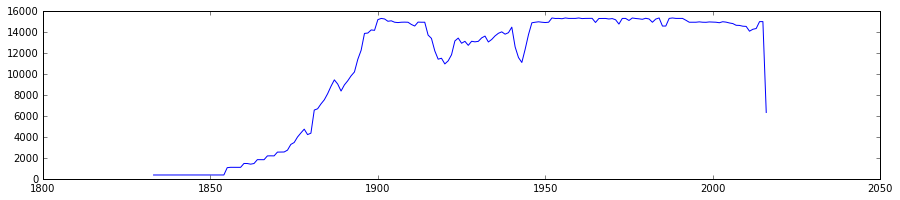

In [47]:
# Se representa la evolución del número de observaciones desde 1900
plt.plot(df_europa_agg.year,df_europa_agg.NOBS)

Aun así en la primera parte del siglo XX se observa que algunas estaciones dejan de proporcionar datos, para a continuación empezar a volver a generarlos a partir de 1950, por las fechas, parecería ser debido a las guerras mundiales, debemos eliminar dichas estaciones


In [48]:
conn.close()